# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Your Own Analysis](#eda_continued)

<a id='intro'></a>
## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, we will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. We will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. We will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If you visit these pages, you will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly. **However, you do not need to download the data yourself.** The data has already been collected for you in the `/data/` folder of the project files. While the original data for 2016 is spread among multiple files for each city, the files in the `/data/` folder collect all of the trip data for the year into one file per city. Some data wrangling of inconsistencies in timestamp format within each city has already been performed for you. In addition, a random 2% sample of the original data is taken to make the exploration more manageable. 

**Question 2**: However, there is still a lot of data for us to investigate, so it's a good idea to start off by looking at one entry from each of the cities we're going to analyze. Run the first code cell below to load some packages and functions that you'll be using in your analysis. Then, complete the second code cell to print out the first trip recorded from each of the cities (the second line of each data file).

> **Tip**: You can run a code cell like you formatted Markdown cells above by clicking on the cell and using the keyboard shortcut **Shift** + **Enter** or **Shift** + **Return**. Alternatively, a code cell can be executed using the **Play** button in the toolbar after selecting it. While the cell is running, you will see an asterisk in the message to the left of the cell, i.e. `In [*]:`. The asterisk will change into a number to show that execution has completed, e.g. `In [1]`. If there is output, it will show up as `Out [1]:`, with an appropriate number to match the "In" number.

In [1]:
# Importing packages and functions
import csv # reading and writing to CSV files
import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.
import pandas as pd # converts CSV files into dataframes which are more 
                    # practical to use than plain text
import numpy as np # performs calculations
import matplotlib as mpl # Still required to change the sizes of plots

In [2]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    # Read the first from from the dataf file and store it in a variable
    with open(filename, 'r') as f_in:
        
        # Use the csv library to set up a DictReader object.
        trip_reader = csv.DictReader(f_in)
        
        #  Use a function on the DictReader object to read the
        #  first trip from the data file and store it in a variable.
        first_trip = next(trip_reader)
        
        #  Use the pprint library to print the first trip. 
        pprint(first_trip)
        
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary to check the code works
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

<a id='condensing'></a>
### Condensing the Trip Data

We will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, you will convert the Washington labels to match the other two.


**Question 3a**: Complete the helper functions in the code cells below to address each of the cleaning tasks described above.

In [3]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    """
    
    if city == 'NYC':
        duration = float(datum['tripduration']) /60
        
    elif city == 'Chicago':
        duration = float(datum['tripduration']) /60
        
    else:
        duration = float(datum['Duration (ms)']) / 60000
    
    return duration


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [4]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    """

    from datetime import datetime
    if city == 'NYC':
        starttime = datum['starttime']
        d1 = datetime.strptime(starttime, '%m/%d/%Y %H:%M:%S') 
        day_of_week=d1.strftime('%A')
        return (d1.month, d1.hour, day_of_week)
    elif city == 'Chicago':
        starttime = datum['starttime']
        d2 = datetime.strptime(starttime, '%m/%d/%Y %H:%M') 
        day_of_week=d2.strftime('%A')
        return (d2.month, d2.hour, day_of_week)
    elif city == 'Washington':
        starttime = datum['Start date']
        d3 = datetime.strptime(starttime, '%m/%d/%Y %H:%M') 
        day_of_week=d3.strftime('%A')
        return (d3.month, d3.hour, day_of_week)

In [5]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    """
    if city == 'NYC':
        user_type = datum['usertype']
    elif city == 'Chicago':
        user_type = datum['usertype']
    elif city == 'Washington':
        if datum['Member Type'] == 'Registered':
            user_type = 'Subscriber'
        else:
            user_type = 'Customer'
     
    return user_type

**Question 3b**: Now, use the helper functions you wrote above to create a condensed data file for each city consisting only of the data fields indicated above. In the `/examples/` folder, you will see an example datafile from the [Bay Area Bike Share](http://www.bayareabikeshare.com/open-data) before and after conversion. Make sure that your output is formatted to be consistent with the example file.

In [6]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    
    HINT: See the cell below to see how the arguments are structured!
    """
    import csv
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}

            ## TODO: use the helper functions to get the cleaned data from  ##
            ## the original data dictionaries.                              ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above.         ##
            month, hour, day_of_week = time_of_trip(row, city)
            new_point[out_colnames[0]] = duration_in_mins(row, city)
            new_point[out_colnames[1]] = month
            new_point[out_colnames[2]] = hour
            new_point[out_colnames[3]] = day_of_week
            new_point[out_colnames[4]] = type_of_user(row, city)
    
            trip_writer.writerow(new_point)            

In [7]:
# Run this cell to check your work
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now that we have the data collected and wrangled, you're ready to start exploring the data. In this section we will write some code to compute descriptive statistics from the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. The second cell runs this function on the example Bay Area data in the `/examples/` folder. Modify the cells to answer the question below.

**Question 4a**: Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?

**Answer**:
Highest number of tripes : NYC<br/>
Highest Proportion of trips made by subscribers: NYC<br/>
Highest Proportion of trips made by short-term customers: Chicago



In [8]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        sub_proportion = (n_subscribers / n_total) * 100
        cus_proportion = (n_customers / n_total) * 100
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_total, sub_proportion, cus_proportion)

In [9]:
## Modify this and the previous cell to answer Question 4a. Remember to run ##
## the function on the cleaned data files you created from Question 3.      ##

data_file = ['./data/Washington-2016-Summary.csv', './data/Chicago-2016-Summary.csv', './data/NYC-2016-Summary.csv']
for datafile in data_file:
    print(number_of_trips(datafile))

(51753, 14573, 66326, 78.0282242257938, 21.971775774206193)
(54982, 17149, 72131, 76.22520136973007, 23.774798630269924)
(245896, 30902, 276798, 88.83590199351151, 11.164098006488485)


Now, you will write your own code to continue investigating properties of the data.

**Question 4b**: Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

**Answer**:
The Average trip of lenght for each city:
Washington : 18.93
Chicago: 16.56
NYC: 15.81

The proportion of riders made in each city that are longer than 30 minutes:
Washington : 10.83%
Chicago: 8.33%
NYC: 7.30%

In [10]:
def length_of_trips(filename):
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        n = 0
        m = 0
        total = 0
        for row in reader:
            n += 1
            duration = float(row['duration'])
            total = total + duration
            if duration > 30:
                m += 1
        
        average_length = total / n
        proportion = (m/n)*100
        
        return (n, m, proportion, total, average_length)

In [11]:
data_file = ['./data/Washington-2016-Summary.csv', './data/Chicago-2016-Summary.csv', './data/NYC-2016-Summary.csv']
for datafile in data_file:
    print(length_of_trips(datafile))

(66326, 7189, 10.83888671109369, 1255741.7716833346, 18.93287355913721)
(72131, 6010, 8.332062497400562, 1194751.1499999992, 16.563629368787335)
(276798, 20213, 7.3024371563378345, 4376894.116666754, 15.81259299802294)


**Question 4c**: Dig deeper into the question of trip duration based on ridership. Choose one city. Within that city, which type of user takes longer rides on average: Subscribers or Customers?

**Answer**: NYC. Customers take longer rides on average

In [12]:
def duration_ridership(filename):
    with open(filename, 'r') as f_in:  
        reader = csv.DictReader(f_in)
        a = 0
        a_total = 0
        b = 0
        b_total = 0
        total = 0
        for row in reader:
            user_type = row['user_type'] 
            duration = float(row['duration'])
            if user_type == 'Subscriber':
                a += 1
                a_total += duration
            elif user_type == 'Customer':
                b += 1 
                b_total += duration
        
        average_sub = a_total / a
        average_cus = b_total / b
        
        return (a, b, average_sub, average_cus)

In [13]:
data_file = ['./data/NYC-2016-Summary.csv']
for datafile in data_file:
    print(duration_ridership(datafile))

(245896, 30185, 13.680790523907177, 32.982004306775025)


<a id='visualizations'></a>
### Visualizations

The last set of values that you computed should have pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. In order to do this, a new library will be introduced here, `matplotlib`. Run the cell below to load the library and to generate an example plot.

Text(0.5, 0, 'Duration(m)')

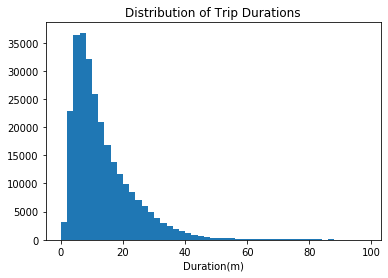

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as py
%matplotlib inline 


trip_times = pd.read_csv('./data/NYC-2016-Summary.csv') 
duration = trip_times['duration']
bins = py.arange(0,100,2)
plt.hist(duration, bins)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration(m)')

In the above cell, we collected fifty trip times in a list, and passed this list as the first argument to the `.hist()` function. This function performs the computations and creates plotting objects for generating a histogram, but the plot is actually not rendered until the `.show()` function is executed. The `.title()` and `.xlabel()` functions provide some labeling for plot context.

You will now use these functions to create a histogram of the trip times for the city you selected in question 4c. Don't separate the Subscribers and Customers for now: just collect all of the trip times and plot them.

If you followed the use of the `.hist()` and `.show()` functions exactly like in the example, you're probably looking at a plot that's completely unexpected. The plot consists of one extremely tall bar on the left, maybe a very short second bar, and a whole lot of empty space in the center and right. Take a look at the duration values on the x-axis. This suggests that there are some highly infrequent outliers in the data. Instead of reprocessing the data, you will use additional parameters with the `.hist()` function to limit the range of data that is plotted. Documentation for the function can be found [[here]](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist).

**Question 5**: Use the parameters of the `.hist()` function to plot the distribution of trip times for the Subscribers in your selected city. Do the same thing for only the Customers. Add limits to the plots so that only trips of duration less than 75 minutes are plotted. As a bonus, set the plots up so that bars are in five-minute wide intervals. For each group, where is the peak of each distribution? How would you describe the shape of each distribution?

**Answer**: For subscriber group, the peak of trip durations is 5-10 minutes. For customer group, the peak of trip durations is 20-25 minutes. The shape of the distribution of trip durations for subscribers is skewed to the right, with more points on the right side of the graph. The shape of the distribution of trip durations for customers is more likely to the normal distribution (bell-shape) compared to the former one. But it is also skewed to the right.

Text(0.5, 0, 'Duration(m)')

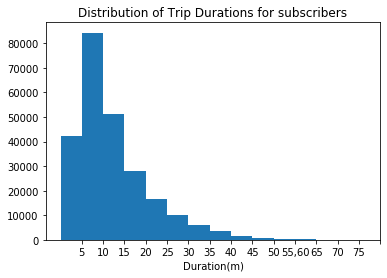

In [17]:
subscribers = trip_times.query('user_type == "Subscriber"')
subscribers2 = subscribers.query('duration < 75')
duration = subscribers2['duration']
bins = py.arange(0,75,5)

plt.hist(duration, bins)
locations = bins + 5
labels = ['5','10','15','20','25','30','35','40','45','50','55,''60','65','70','75']
plt.xticks(locations, labels)
plt.title('Distribution of Trip Durations for subscribers')
plt.xlabel('Duration(m)')

Text(0.5, 0, 'Duration(m)')

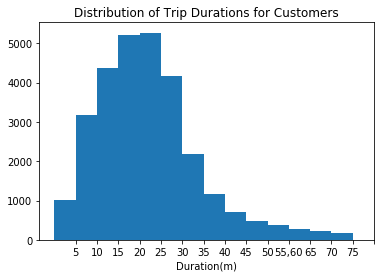

In [18]:
customers = trip_times.query('user_type == "Customer"')
customers2 = customers.query('duration < 75')
duration = customers2['duration']
bins = py.arange(0,75,5)

plt.hist(duration, bins)
locations = bins + 5
labels = ['5','10','15','20','25','30','35','40','45','50','55,''60','65','70','75']
plt.xticks(locations, labels)
plt.title('Distribution of Trip Durations for Customers')
plt.xlabel('Duration(m)')

<a id='eda_continued'></a>
## Performing Your Own Analysis

So far, you've performed an initial exploration into the data available. You have compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For one of these cities, you have investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. Now it is your turn to continue the exploration in a direction that you choose. Here are a few suggestions for questions to explore:

- How does ridership differ by month or season? Which month / season has the highest ridership? Does the ratio of Subscriber trips to Customer trips change depending on the month or season?
- Is the pattern of ridership different on the weekends versus weekdays? On what days are Subscribers most likely to use the system? What about Customers? Does the average duration of rides change depending on the day of the week?
- During what time of day is the system used the most? Is there a difference in usage patterns for Subscribers and Customers?

If any of the questions you posed in your answer to question 1 align with the bullet points above, this is a good opportunity to investigate one of them. As part of your investigation, you will need to create a visualization. If you want to create something other than a histogram, then you might want to consult the [Pyplot documentation](https://matplotlib.org/devdocs/api/pyplot_summary.html). In particular, if you are plotting values across a categorical variable (e.g. city, user type), a bar chart will be useful. The [documentation page for `.bar()`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.bar.html#matplotlib.pyplot.bar) includes links at the bottom of the page with examples for you to build off of for your own use.

**Question 6**: Continue the investigation by exploring another question that could be answered by the data available. Document the question you want to explore below. Your investigation should involve at least two variables and should compare at least two groups. You should also use at least one visualization as part of your explorations.

**Answer**:
**Question** What are popular times for Subscribers and Customers? This will help determine usage patterns to later look at price points, discounts, etc. akin to Happy Hours.
City : Chicago.
Variables : 'hours' and 'user_type'.
For Customers, popular time was 14-14.5, i.e. 2-2.30pm.
For Subscribers, popular time was at 16.5-17, i.e 4.30-5pm.

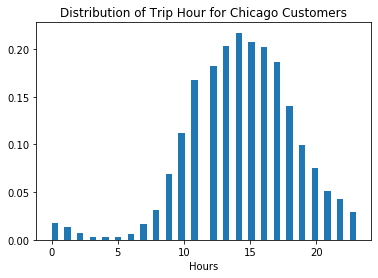

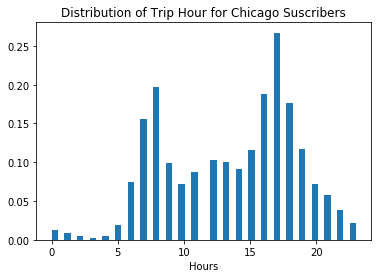

In [20]:
import matplotlib.pyplot as plt
# this is a 'magic word' that allows for plots to be displayed
# inline with the notebook. If you want to know more, see:
# http://ipython.readthedocs.io/en/stable/interactive/magics.html
%matplotlib inline 


def user_month_plot(filename):
    """
    This function reads in a file with trip data and appends hour for each trip.
    The field is appended to either subscriber list or customer list based on user type.
    We return this list to later plot a histogram of the values
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_trips_s = []
        n_trips_c = []


        # tally up ride durations
        for row in reader:
            if (row['user_type'] == 'Customer'):
                n_trips_c.append(float(row['hour']))
            else:
                n_trips_s.append(float(row['hour']))
        return (n_trips_s,n_trips_c)

data = user_month_plot('./data/Chicago-2016-Summary.csv')
#print(data)

val_s = data[0]
val_c = data[1]

plt.hist(val_c, density=True, bins=48,stacked='stacked')
plt.title('Distribution of Trip Hour for Chicago Customers')
plt.xlabel('Hours')
plt.show()

plt.hist(val_s, density=True, bins=48,stacked='stacked')
plt.title('Distribution of Trip Hour for Chicago Suscribers')
plt.xlabel('Hours')
plt.show()


In [22]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Bike_Share_Analysis.ipynb'])

0